In [1]:
# External libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import requests

# helpful check routine
def is_downloadable(url):
    """
    Does the url contain a downloadable resource
    """
    h = requests.head(url, allow_redirects=True)
    header = h.headers
    content_type = header.get('content-type')
    if 'text' in content_type.lower():
        return False
    if 'html' in content_type.lower():
        return False
    return True

In [2]:
# CSI routines
import csi.planarfault as pf
import csi.gps as gr
import csi.insar as insar
import csi.geodeticplot as geoplt
import csi.seismiclocations as sl
import csi.imagedownsampling as down
import csi.fault3D as flt3D
import csi.faultwithvaryingdip as flt
import csi.verticalfault as verticalfault
#import csi.cosicorrrates as cr
import csi.imagecovariance as imcov


In [3]:
# set some flags
input_check = True
do_downsample = False
output_check = False

CSI does most computations in a local Cartesian coordinate system. It presently supports only UTM projections, so we need to set the zone to use.

In [4]:
# UTM zone 11 for eastern California
utmzone = 11

For this example, we will use an InSAR dataset for the 2019 Ridgecrest earthquake, published online at the Harvard Dataverse:

Fielding, Eric Jameson, 2019, "Replication Data for: Surface deformation related to the 2019 Mw 7.1 and Mw 6.4 Ridgecrest Earthquakes in California from GPS, SAR interferometry, and SAR pixel offsets", https://doi.org/10.7910/DVN/JL9YMS, Harvard Dataverse, V2

The dataset we will work with is an ALOS-2 wide-swath interferogram from descending track 166.

The fastest way to get the datasets from the Harvard Dataverse is to go to the DOI URL listed above that will redirect to the actual Dataverse site: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JL9YMS

In the search box, you can search for "*D166*" (without the quotes but including the asterisks) to find the files for the D166 track. Select all the files and then the `download` button will download a zip file of the files, or you can download each file separately. The data files are about 93 MB each because the ALOS-2 ScanSAR interferogram is about 350 by 350 km. There are four data files and a map figure from the SRL article that is embedded below. The map shows the interferogram range change in the area of Ridgecrest coseismic rupture  that is a small part of the full interferogram.
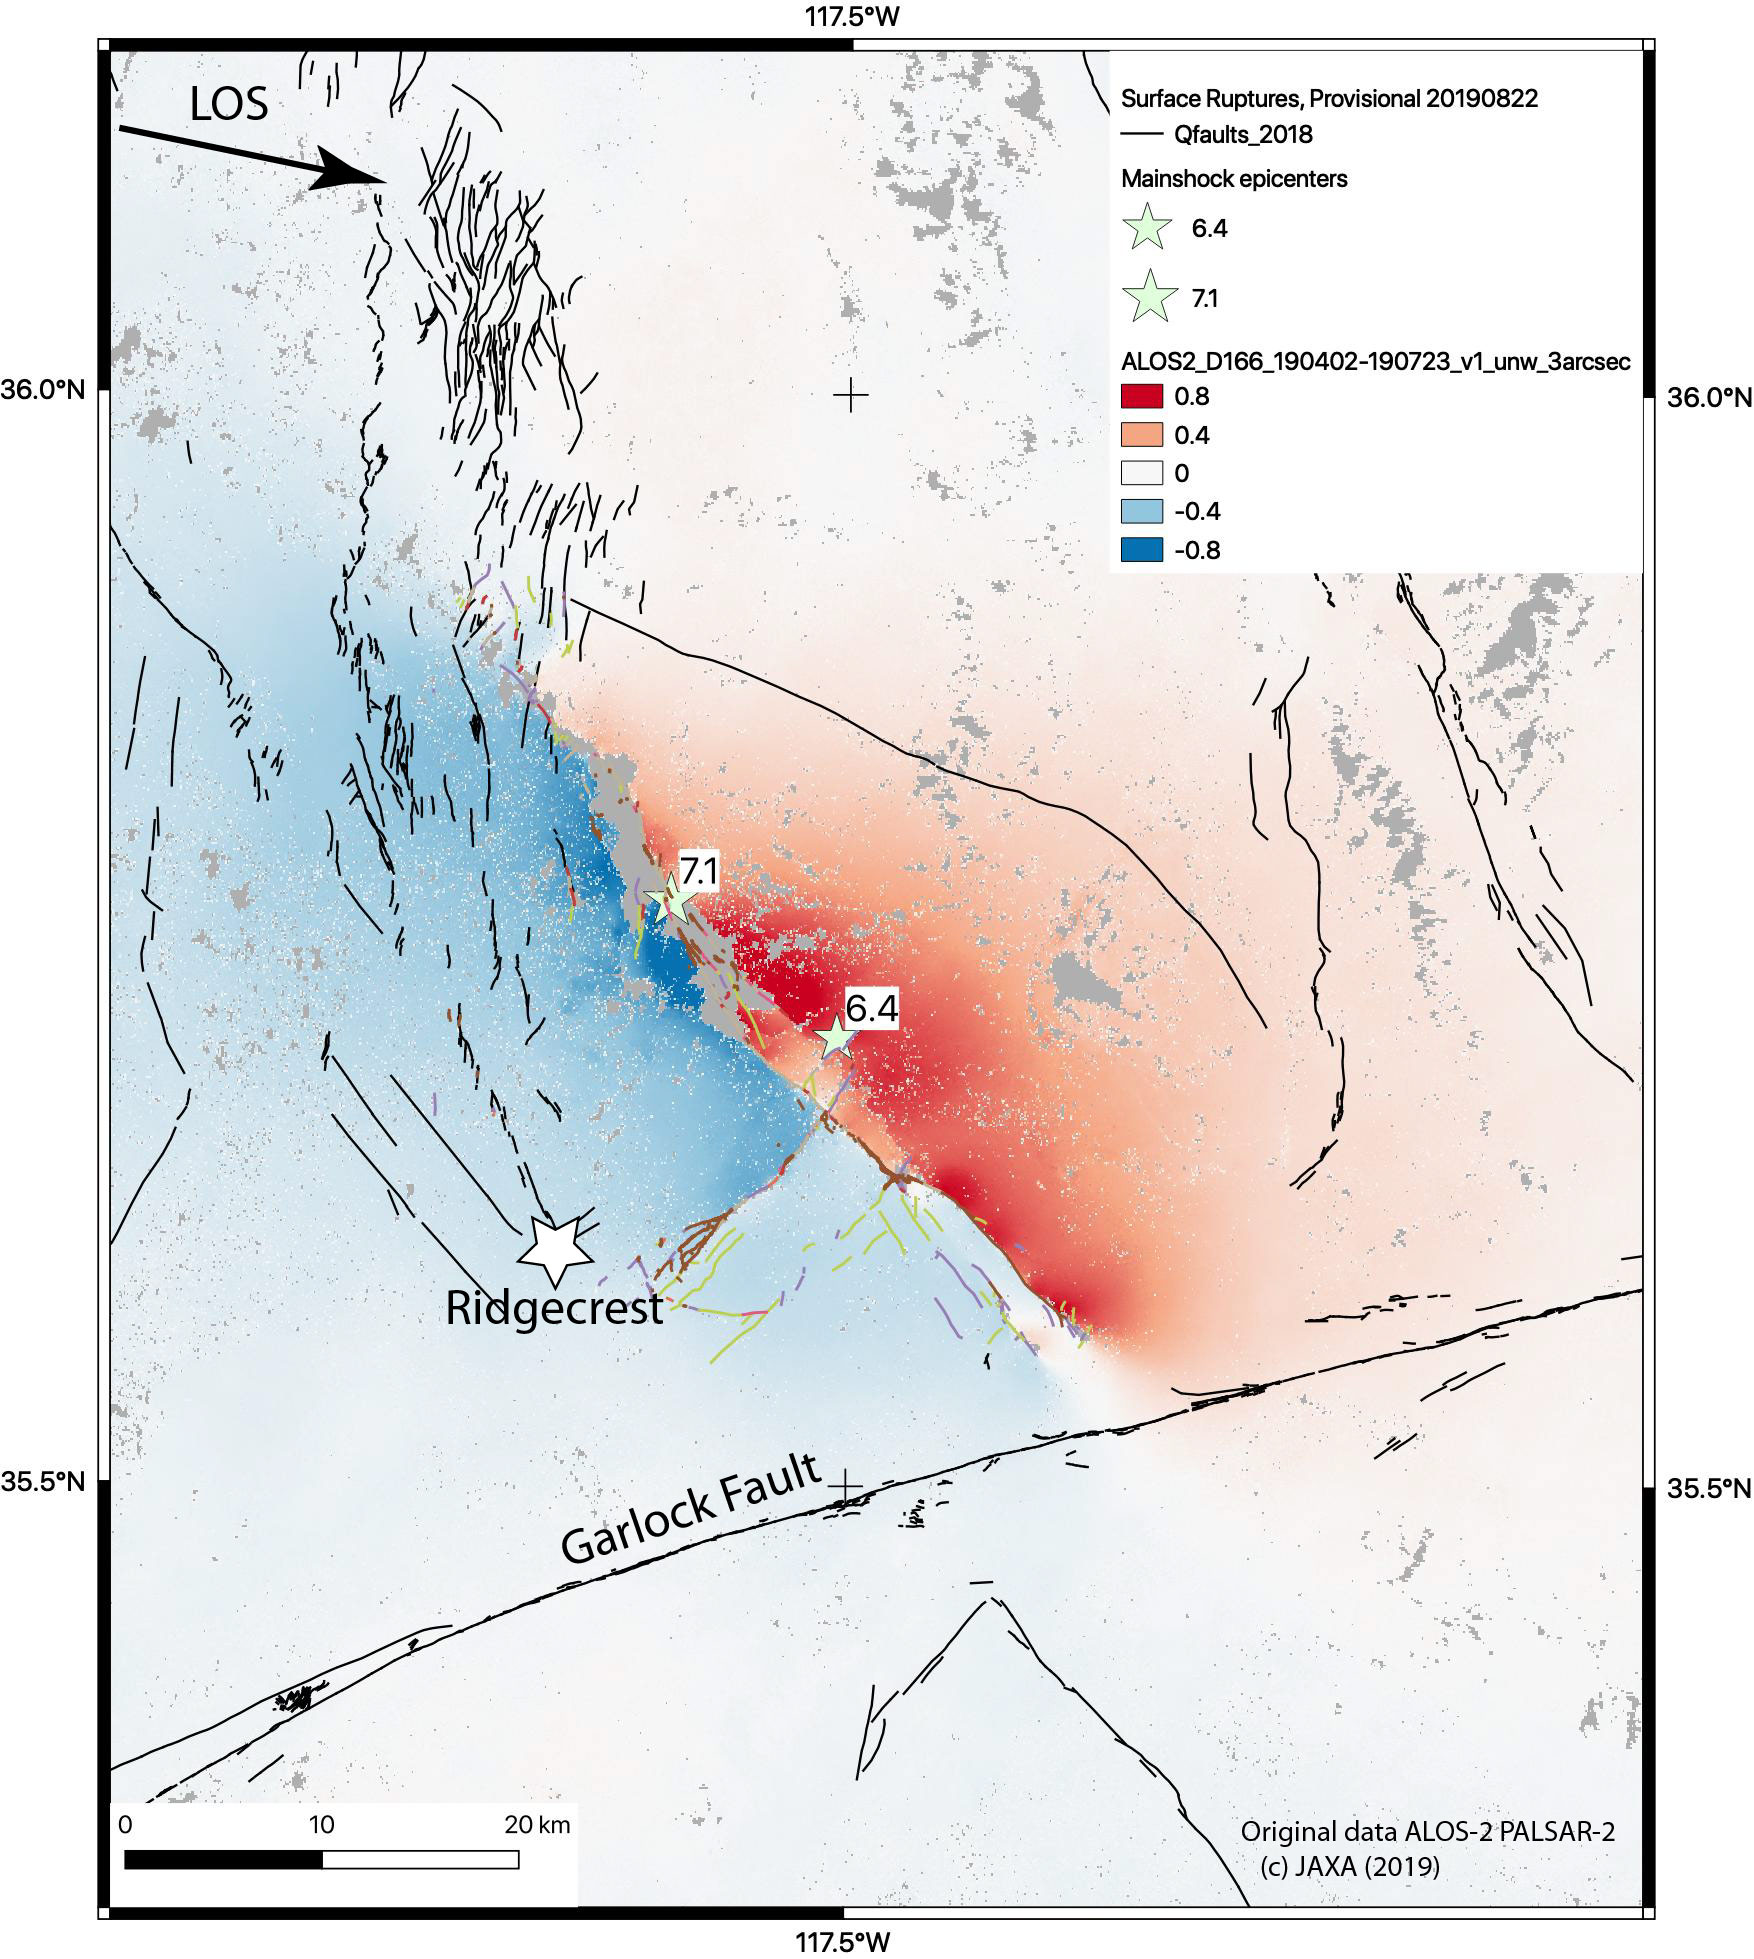

We set the output name for the dataset below.

In [5]:
# set the output name root
outName = 'A2D166'  # ALOS-2 Descending track 166

The range-change file is the interferogram converted to range-change in meters and this range-change file has already been masked to remove areas of low coherence (gray in the above map). We can use the `requests` library to download the file to the local directory from Python (if you did not click on the links at the main Dataverse URL above which is faster). The code below will download the file if it does not already exist in the directory.

In [6]:
# range-change file name locally
d166_rng='ALOS2_D166_190402-190723_v1_range_change_m_3arcsec.grd'
if os.path.exists(d166_rng) == False:   # if the file not here yet
    # store direct download url of range-change dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/GDQUXT'
    if is_downloadable(url): # does URL point to a file?
        # Download data into a requests variable with the above url
        r = requests.get(url, allow_redirects=True)
        # Write the content of above request variable to the file name
        open(d166_rng, 'wb').write(r.content)


We also need the three components of the line-of-sight (LOS) vector: East, North, and Up. The code below will also download those files if you don't have them.

In [8]:
# East file name locally
d166_east='ALOS2_D166_190402-190723_v1_east_3arcsec.grd'
if os.path.exists(d166_east) == False:   # if the file not here yet
    # store direct download url of East dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/QJ1VEZ'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # We are writing the content of above request to the file name
    open(d166_east, 'wb').write(r.content)

# North file name locally
d166_north='ALOS2_D166_190402-190723_v1_north_3arcsec.grd'
if os.path.exists(d166_north) == False:   # if the file not here yet
    # url of North dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/RPYZO2'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # Write the content of above request variable to the file name
    open(d166_north, 'wb').write(r.content)

# Up file name locally
d166_up='ALOS2_D166_190402-190723_v1_up_3arcsec.grd'
if os.path.exists(d166_north) == False:   # if the file not here yet
    # url of North dataset
    url='https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/JL9YMS/6KSXYH'
    # Download data into a requests variable with the above url
    r = requests.get(url, allow_redirects=True)
    # Write the content of above request variable to the file name
    open(d166_up, 'wb').write(r.content)


Now we are ready to create a CSI InSAR object with this dataset.

In [9]:
# Instantiate a insar object
sar = insar('A2_D166_coseismic', utmzone=utmzone)
#print ('reading from GMT grd files',d166_rng) # print is a little redundant
sar.read_from_grd( d166_rng, los=[d166_east, d166_north, d166_up])


---------------------------------
---------------------------------
Initialize InSAR data set A2_D166_coseismic
Read from file ALOS2_D166_190402-190723_v1_range_change_m_3arcsec.grd into data set A2_D166_coseismic


Check the dataset for NaN (no data in GMT) pixels and remove them.

In [10]:
# clean out NaNs if present
sar.checkNaNs()


We can use the `plot` method of the InSAR class to plot the dataset and check that it was read correctly. The `input_check` flag above controls whether this is done. This step can take a while for large images. The `norm` parameter controls the color scale.

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


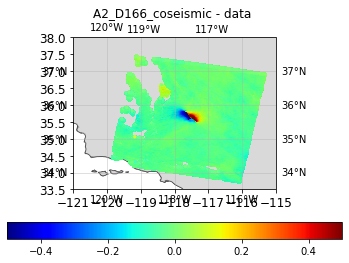

In [11]:
# check data read in if flag set
if input_check:
    sar.plot(faults=None,figure=127,norm=[-0.5,0.5])

You should see the Ridgecrest earthquake signal in the middle of the scene. The 350 km wide swath makes the magnitude 7.1 earthquake look small. Now we can estimate the covariance of the dataset using the semivariogram method. First we create a image covariance object from the InSAR object.

In [12]:
# Covariance first estimate on original data
covar = imcov('Covariance estimator',sar, verbose=True)

---------------------------------
---------------------------------
Initialize InSAR covariance tools Covariance estimator


We will mask out the area close to the main rupture to look at the covariance of the rest of the scene with the `maskOut` method specifying the longitude and latitude of a rectangular box to mask out.

In [13]:
# mask out high deformation above earthquake rupture
covar.maskOut([[-118.0, -117.25, 35.55, 35.95]])

Masking data set Covariance estimator
     Mask: -118.0 <= Lon <= -117.25 || 35.55 <= Lat <= 35.95


We use the `computeCovariance` method to sample the dataset with a random set on 0.002 of the pixels, estimate and remove a ramp, calculate the semivariogram at distances of every 2 km out to 100 km, convert the semivariogram to covariance, and estimate a fit of an exponential function vs. distance.

In [18]:
covar.computeCovariance(function='exp', frac=0.002, every=2.0, distmax=100., rampEst=True)

Computing covariograms
Computing 1-D empirical semivariogram function for data set Covariance estimator
Selecting 26454 random samples to estimate the covariance function
Estimated Orbital Plane: 1.9857052453834199e-07xy + -0.0007732318571158395x + -9.759931229288044e-06y + 0.003957152006794069
Build the permutations
Digitize the histogram
Fitting Covariance functions
Dataset Covariance estimator:
A prior values: Sill | Sigma | Lambda
                 0.000319 | 0.000673 | 50.325385
Dataset Covariance estimator:
     Sill   :  8.897360852605843e-05
     Sigma  :  0.032833715885601654
     Lambda :  50.32538399011381


Now we can plot the results with the `plot` method. Because the set of samples is random and changes every time you run the method, if you see the fit is not fitting well in the plot below, then you can rerun the sampling and covariance calculation and the plot.

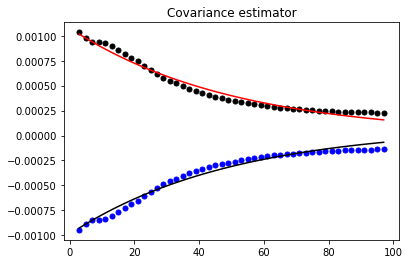

In [19]:
covar.plot(data='all')

Save the exponential fit to a file with the default output name `Covariance_estimator.cov` for use in estimating the data covariance of downsampled data.

In [20]:
covar.write2file(savedir='./')

writing covariance output for Covariance estimator
